In [2]:
# Deep CNN(Convolutional Neural Network) - CIFAR10 Dataset
# airplane(0),automobile(1),bird(2),cat(3),deer(4),dog(5),frog(6),horse(7),ship(8),truck(9)
# CIFAR10 데이터에서 가각의 이미지는 32x32 크기의 작은 컬러 이미지
# 32 x 32 x 3 형상(shape)을 가지는 아주 작은 컬러 데이터

# 딥러닝 Deep CNN 아키텍처
# [<Feature Extractor>
# conv1>relu>conv2>relu>pooling>dropout -> conv3>relu>conv4>relu>pooling>dropout ->
# conv5>relu>pooling>dropout -> conv6>relu>pooling>dropout -> conv7>relu>pooling>dropout]

# [ <Fully-Connected>
# Flatten]

# [<Classification>
# fc1>relu>Dropout -> fc2 ]

In [3]:
# 1) import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [ ]:
# 2) CIFAR10 Dataset 다운로드

# CIFAR10 Dataset 데이터 증강(augmentation) 및 정규화 설정
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# CIFAR10 Dataset에는 데이터 증강(augmentation) 없이 정규화만 수행 하는것이 정확도 향상에 더 효과적
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
])

# train
train_dataset = datasets.CIFAR10(root='./data/CIFAR10_data',
                               train=True,
                               transform=transform,
                               download=True)
# test
test_dataset = datasets.CIFAR10(root='./data/CIFAR10_data',
                               train=False,
                               transform=transform,
                               download=True)

In [5]:
# CIFAR10 Dataset 확인
print(len(train_dataset), len(test_dataset))

50000 10000


In [6]:
# 3) CIFAR10 Dataset 데이터 분리 - train 85% : validation 15%
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
# validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
validation_dataset_size = len(train_dataset) - train_dataset_size # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [7]:
# CIFAR10 Dataset 데이터 분리 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

42500 7500 10000


In [8]:
# 4) batch, dataloader 생성
BATCH_SIZE = 64

# num_workers 옵션 추가 (CPU 코어 수에 맞게 2~8 사이로 조정)
# train
train_dataset_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8
)

# validation
validation_dataset_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8
)

# test
test_dataset_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8
)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


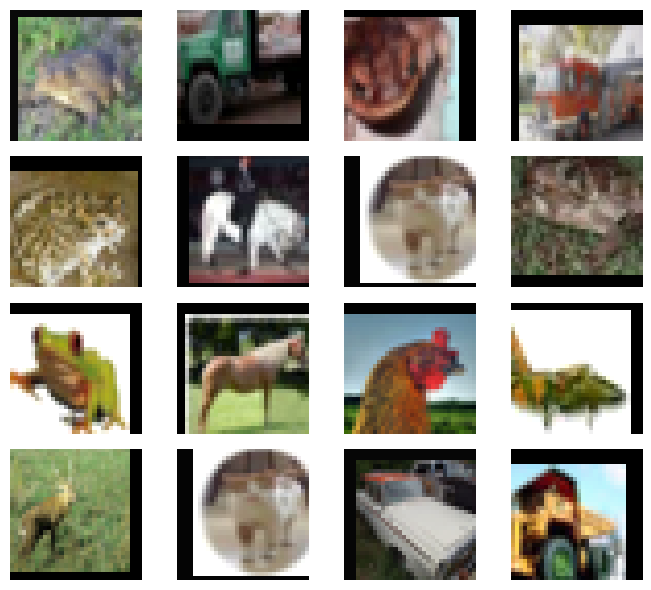

In [9]:
# 5) CIFAR10 Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    img = img * 0.5 + 0.5 # 복원
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# 6) 딥러닝 Deep CNN 아키텍처

# <Feature Extractor>
# conv1>relu>conv2>relu>pooling>dropout -> conv3>relu>conv4>relu>pooling>dropout ->
# conv5>relu>pooling>dropout -> conv6>relu>pooling>dropout -> conv7>relu>pooling>dropout

# <Fully-Connected>
# Flatten 

# <Classification>
# fc1>relu>Dropout -> fc2

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # conv1, conv2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # conv3, conv4
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # conv5
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # conv6
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        # conv7
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
                
        # pooling
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fc1, fc2
        self.fc1 = nn.Linear(1 * 1 * 256, 128)
        self.fc2 = nn.Linear(128, 10)

        # dropout
        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # 패딩이 적용되었기 때문에 컨볼루션층을 통과한 데이터는 크기는 변하지 않고 필터 개수와 동일하게 출력채널 개수만 변함
        # 맥스풀링층을 통과한 데이터는 1/2로 바뀌지만 채널 개수는 변하지 않음

        # conv1, conv2 data shape = (H, W, C) = (32, 32, 3)
        x = self.conv1(x) # (32, 32, 3)
        x = torch.relu(x) # (32, 32, 32)
        x = self.conv2(x) # (32, 32, 32)
        x = torch.relu(x) # (32, 32, 32)
        x = self.pooling(x) # (32, 32, 32)
        x = self.dropout25(x) # (16, 16, 32)

        # conv3, conv4
        x = self.conv3(x) # (16, 16, 32)
        x = torch.relu(x) # (16, 16, 64)
        x = self.conv4(x) # (16, 16, 64)
        x = torch.relu(x) # (16, 16, 64)
        x = self.pooling(x) # (16, 16, 64)
        x = self.dropout25(x) # (8, 8, 64)

        # conv5
        x = self.conv5(x) # (8, 8, 64)
        x = torch.relu(x) # (8, 8, 128)
        x = self.pooling(x) # (8, 8, 128)
        x = self.dropout25(x) # (4, 4, 128)

        # conv6
        x = self.conv6(x) # (4, 4, 128)
        x = torch.relu(x) # (4, 4, 128)
        x = self.pooling(x) # (4, 4, 128)
        x = self.dropout25(x) # (2, 2, 128)

        # conv7
        x = self.conv7(x) # (2, 2, 128)
        x = torch.relu(x) # (2, 2, 256)
        x = self.pooling(x) # (2, 2, 256)
        x = self.dropout25(x) # (1, 1, 256)

        # (높이,너비,채널)3차원 텐서이므로 완전연결층(Fully-Connected)과 연결을 위해 view() 명령어를 이용해서 3차원 텐서를 1차원 vector로 만들어 주는 역할
        # view(-1, 벡터크기) 이용해서 배치차원은 유지되고 3차원 텐서는 1차원 벡터로 변환됨
        x = x.view(-1, 1 * 1 * 256)

        # Linear
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout50(x)
        
        x = self.fc2(x)

        return x

In [11]:
# 7) Model 객체 생성
model = CNNModel().to(DEVICE)

# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Model 정보
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


In [12]:
# 8) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# 9) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function, optimizer):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# 10) Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [15]:
# 11) Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 200

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  1.945756 , train acc =  23.800000 val loss =  1.697366 , val acc =  34.613333
epoch :  02 train loss =  1.615352 , train acc =  38.409412 val loss =  1.411534 , val acc =  46.226667
epoch :  03 train loss =  1.438593 , train acc =  47.287059 val loss =  1.245244 , val acc =  53.813333
epoch :  04 train loss =  1.300794 , train acc =  53.105882 val loss =  1.175552 , val acc =  57.026667
epoch :  05 train loss =  1.200667 , train acc =  57.421176 val loss =  1.083168 , val acc =  61.293333
epoch :  06 train loss =  1.136317 , train acc =  60.185882 val loss =  0.980240 , val acc =  65.306667
epoch :  07 train loss =  1.081517 , train acc =  62.272941 val loss =  0.959756 , val acc =  66.080000
epoch :  08 train loss =  1.039163 , train acc =  63.738824 val loss =  0.894359 , val acc =  68.453333
epoch :  09 train loss =  1.012807 , train acc =  65.087059 val loss =  0.925272 , val acc =  66.906667
epoch :  10 train loss =  0.985195 , train acc =  66.044706 val 

In [16]:
# 12) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

accuracy =  81.58 , loss =  0.5818373629241992


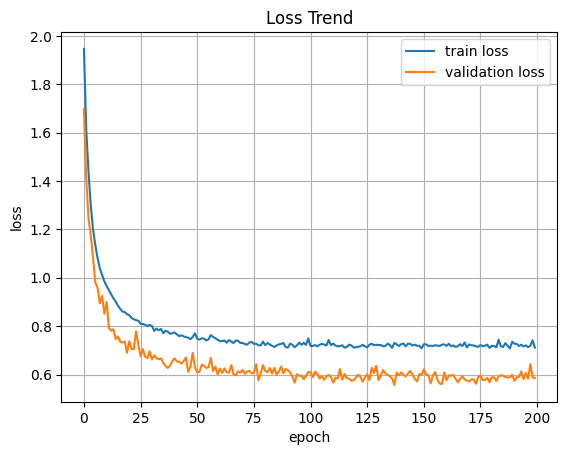

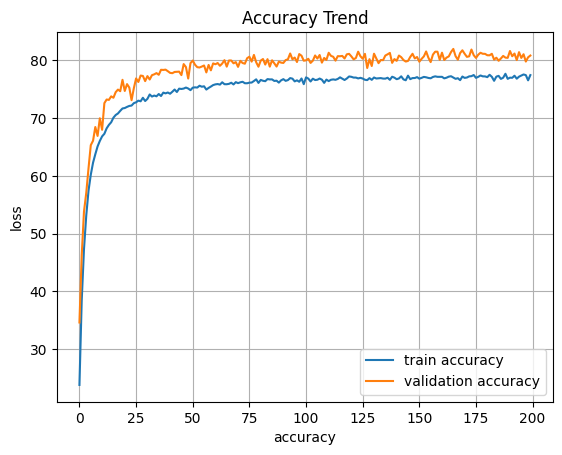

In [17]:
# 13 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [18]:
# 14) Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_deep_cnn_cifar10.ckpt')

In [19]:
# 15) 테스트 - 모델 추론 및 예측값 추출
model = CNNModel().to(DEVICE)
model.load_state_dict(torch.load('.\\models\\model_deep_cnn_cifar10.ckpt'))

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


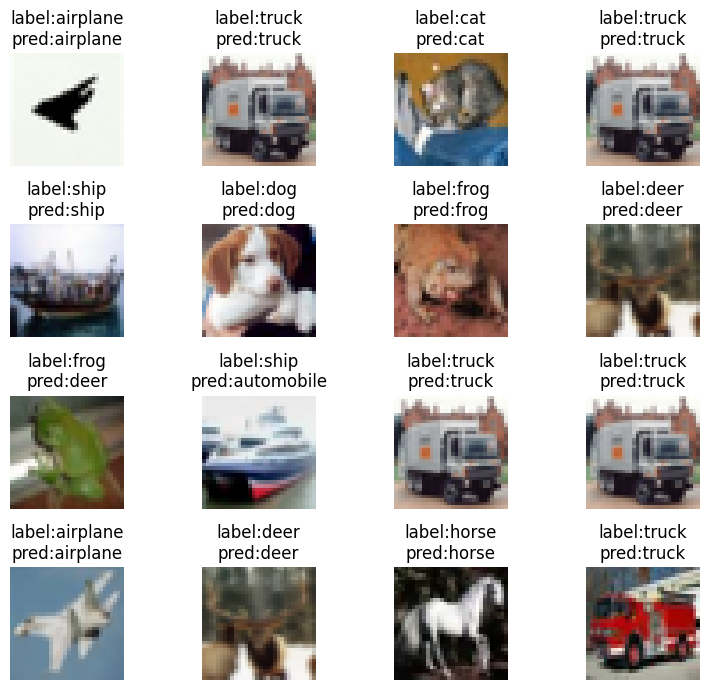

In [20]:
# 16) 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    img = img * 0.5 + 0.5 # 복원

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()